In [1]:
import galarp as grp
grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from gala.units import galactic

from gala import potential as gp

from scipy import stats

In [2]:
test = gp.MilkyWayPotential()
print(test.parameters)

for key in test.parameters.keys():
    print(key, test.parameters[key], test[key])


{'disk': {'m': <Quantity 6.8e+10 solMass>, 'a': <Quantity 3. kpc>, 'b': <Quantity 0.28 kpc>}, 'bulge': {'m': <Quantity 5.e+09 solMass>, 'c': <Quantity 1. kpc>}, 'nucleus': {'m': <Quantity 1.71e+09 solMass>, 'c': <Quantity 0.07 kpc>}, 'halo': {'m': <Quantity 5.4e+11 solMass>, 'r_s': <Quantity 15.62 kpc>, 'a': <Quantity 1.>, 'b': <Quantity 1.>, 'c': <Quantity 1.>}}
disk {'m': <Quantity 6.8e+10 solMass>, 'a': <Quantity 3. kpc>, 'b': <Quantity 0.28 kpc>} MiyamotoNagaiPotential
bulge {'m': <Quantity 5.e+09 solMass>, 'c': <Quantity 1. kpc>} HernquistPotential
nucleus {'m': <Quantity 1.71e+09 solMass>, 'c': <Quantity 0.07 kpc>} HernquistPotential
halo {'m': <Quantity 5.4e+11 solMass>, 'r_s': <Quantity 15.62 kpc>, 'a': <Quantity 1.>, 'b': <Quantity 1.>, 'c': <Quantity 1.>} NFWPotential


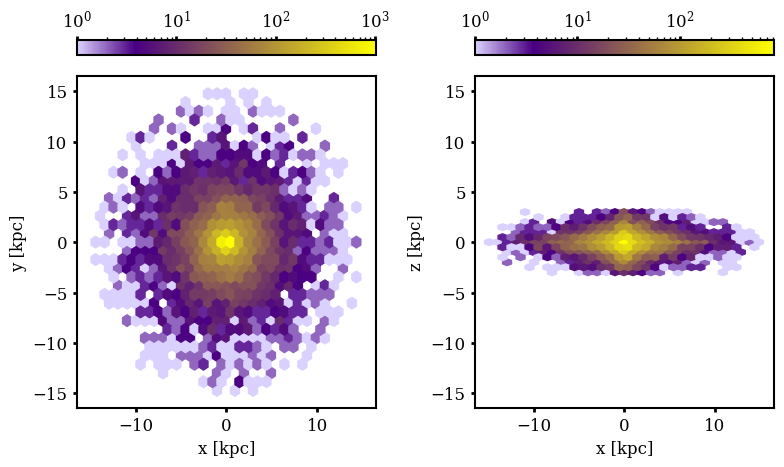

In [3]:
jz2023_satellite = grp.builtins.JZ2023_Satellite()
mass_profile = grp.gen_mass_profile(jz2023_satellite)

particles = grp.ExponentialGrid(h_R=jz2023_satellite["gas"].parameters["a"],
                                h_z=jz2023_satellite["gas"].parameters["b"],
                                n_particles=10000)

particles.generate(mass_profile=mass_profile, positions="temp/positions.npy")

particles.plot_density(cmap=cmap, gridsize=30)

# particles = grp.UniformGrid(n_particles=50)
# particles.generate(mass_profile=mass_profile)

In [7]:
incs = [15, 30, 45, 60, 90]
# incs = [45]

for inc in incs:
    wind = grp.LorentzianWind(t0=1000 * u.Myr, width=500 * u.Myr, units=galactic)
    wind.init_from_inc(inclination=np.deg2rad(inc), strength= 1400 * u.km/u.s)

    shadow = grp.UniformLinearZVariableShadow(damping=0.4, R_disk=3*jz2023_satellite["gas"].parameters["a"].value,
                            zmin=0.5, z_dropoff=40,
                            dynamic=True, debug=True)
    shadow.init_from_wind(wind)


    sim = grp.RPSim(wind=wind, potential=jz2023_satellite, shadow=shadow)
    orbits = sim.run(particles, rho_icm=1e-27 * u.g/u.cm**3, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False)

    grp.density_matrix(orbits, xextent=20, yextent=20, outname=f"figures/dm/density_xy_matrix_{inc}.png", 
                       cmap=cmap, vmax=200,
                       cbar_loc="lower right")

    grp.animated_hexbin_plot(orbits, outname=f"figures/animated/animated_hexbin_{inc}.gif", 
                             n_frames=200, cmap=cmap, xextent=50, 
                             vextent=(-100, 200))



100%|██████████| 399/399 [00:09<00:00, 44.29it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.
100%|██████████| 399/399 [00:08<00:00, 47.60it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.
100%|██████████| 399/399 [00:08<00:00, 47.34it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


In [5]:
def rstrip_and_medians(xyz, rmax=20, zmax=2, frac=0.9):
    x,y,z = xyz
    r = np.sqrt(x**2 + y**2 + z**2)

    rcut = (np.abs(z) < zmax) & (r < rmax)
    
    try:
        cdf = stats.ecdf(r[rcut])
        cdf_xs, cdf_vals = cdf.cdf.quantiles, cdf.cdf.probabilities
        rstrip =  cdf_xs[np.argmin(np.abs(cdf_vals - frac))]
    except:
        rstrip = 0
    
    median_x, median_y, median_z = np.median([x[rcut], y[rcut], z[rcut]], axis=1)
    
    return rstrip, [median_x, median_y, median_z]

x,y,z,vx,vy,vz = grp.get_orbit_data(orbits.data, transposed=False)

index = 250
rstrip_and_medians([x[index], y[index], z[index]])


(3.3296696777282953,
 [0.23470771725617462, -0.05861638788999202, 0.06635326131473337])